# Umaximizer
### Convert images to skill hint information and maximize the evaluation

### Input image information

In [1]:
num_images = 19
prefix = '/Users/SoChigusa/Dropbox/img/IMG_0'
extension='png'
# prefix='img/IMG_075B68F75878-'
# extension='jpg'
start = 602

### Preliminary

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import collections
import json
import pytesseract
from difflib import get_close_matches
from PIL import Image

import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

In [3]:
BLACK = 0
WHITE = 255

In [4]:
def imgshow(src, portrait=False):
    '''docstring
    image display function
    '''
    if type(src) is list:
        list_src = src
    else:
        list_src = [src]
    if not portrait:
        fig = plt.figure(figsize=(8*len(list_src), 16))
        subplot_layout = (1, len(list_src))
    else:
        fig = plt.figure(figsize=(16, 4*len(list_src)))
        subplot_layout = (len(list_src), 1)
    for i, img in enumerate(list_src, 1):
        ax = fig.add_subplot(subplot_layout[0], subplot_layout[1], i)
        if img.ndim == 2:  # gray scale
            ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        elif img.shape[2] == 3:  # BGR
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        elif img.shape[2] == 4:  # BGRA
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))

### Read and process images

In [5]:
def read_images(num_images, prefix, extension='png', start=1, preview=False):
    '''docstring
    read images
    '''

    print('Reading images...')
    images = []
    for i in np.arange(start, start+num_images):
        img = cv2.imread(prefix+str(i)+'.'+extension,
                         cv2.IMREAD_COLOR)
        if i > start:
            if(images[i-start-1].shape[0] != img.shape[0]) | (images[i-start-1].shape[1] != img.shape[1]):
                raise Exception('Images with different resolutions detected')
        images.append(img)

    if preview:
        imgshow(images)

    return images

In [6]:
def combine_images(images, preview=False):
    '''docstring
    combine input images to get a list of skills
    '''

    print('Processing images...')

    # digitization thresholds in HSV
    min = (0, 0, 0)
    max = (255, 255, 245)

    # digitization
    img = images[0]
    height_orig, width_orig, _ = img.shape
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
    inrange = cv2.inRange(hsv, min, max)

    # search left most white points for side margin detection
    positions = []
    for y in np.arange(int(height_orig*0.4), int(height_orig*0.75)):
        for x in np.arange(1, int(width_orig*0.5)):
            if inrange[y, x] == WHITE:
                positions.append(x)
                break

    # side margin detection
    c = collections.Counter(positions)
    margin_left = c.most_common(1)[0][0]
    margin_right = width_orig - margin_left
    width = margin_right - margin_left

    # threshold of white dots ratio for the margin region
    min_ratio = 0.9
    max_ratio = 1.1

    # margin top detection
    after_black = False
    for y in np.arange(int(height_orig*0.25), int(height_orig*0.50)):
        if not after_black:
            cts = np.count_nonzero(
                inrange[y, margin_left:margin_right] == BLACK)
            ratio = cts / width
            if min_ratio < ratio and ratio < max_ratio:
                after_black = True
        else:
            cts = np.count_nonzero(
                inrange[y, margin_left:margin_right] == WHITE)
            ratio = cts / width
            if min_ratio < ratio and ratio < max_ratio:
                margin_top = y-1
                break

    # threshold of black dots ratio for the margin bottom
    min_ratio = 0.4
    max_ratio = 0.8

    # margin bottom detection
    for y in np.arange(int(height_orig*0.65), int(height_orig*0.9)):
        cts = np.count_nonzero(inrange[y, margin_left:margin_right] == BLACK)
        ratio = cts / width
        if min_ratio < ratio and ratio < max_ratio:
            margin_bottom = y-1
            break

    # list of clipped images
    clip_imgs = []
    clip_imgs.append(img[margin_top:margin_bottom, margin_left:margin_right])

    # region used for template matching
    skill_height = int(height_orig*0.08)
    skill_right = margin_left + int((margin_right - margin_left)*0.95)

    for i in np.arange(1, len(images)):

        # clip bottom region of the old image
        skill_img = img[margin_bottom -
                        skill_height:margin_bottom, margin_left:skill_right]

        # new image
        img = images[i]

        # template match
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        skill_gray = cv2.cvtColor(skill_img, cv2.COLOR_BGR2GRAY)
        res = cv2.matchTemplate(img_gray, skill_gray, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # crop
        clip_img = img[max_loc[1]+skill_height:margin_bottom,
                       margin_left:margin_right]
        clip_imgs.append(clip_img)

    # combine clipped images
    height_total = sum(c.shape[0] for c in clip_imgs)
    output_img = np.zeros((height_total, width, 3), dtype=np.uint8)
    y = 0
    for clip_img in clip_imgs:
        output_img[y:y+clip_img.shape[0], :] = clip_img
        y += clip_img.shape[0]

    # preview combine result
    if preview:
        print('Preview combined image:')
        imgshow(output_img)

    # extract skill point
    skill_point = extract_skill_point(images[-1], (margin_top, margin_bottom, margin_left, margin_right))

    return skill_point, output_img

In [7]:
def extract_skill_point(img, margins):

  # input
  (margin_top, margin_bottom, margin_left, margin_right) = margins
  width = margin_right - margin_left

  # digitization thresholds in HSV
  min = (0, 0, 0)
  max = (255, 255, 245)

  # digitization
  height_orig, width_orig, _ = img.shape
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
  inrange = cv2.inRange(hsv, min, max)

  # for horizontal detection
  min_ratio_horizontal = 0.4
  max_ratio_horizontal = 0.8

  # detect top
  for y in np.arange(int(height_orig*0.25), margin_top):
    cts = np.count_nonzero(inrange[y, margin_left:margin_right] == BLACK)
    ratio = cts / width
    if min_ratio_horizontal < ratio and ratio < max_ratio_horizontal:
      skill_point_top = y-1
      break

  # detect bottom
  for y in np.arange(margin_top-1, int(height_orig*0.25), -1):
    cts = np.count_nonzero(inrange[y, margin_left:margin_right] == BLACK)
    ratio = cts / width
    if min_ratio_horizontal < ratio and ratio < max_ratio_horizontal:
      skill_point_bottom = y+1
      break

  # Use 90% of height without borders
  tmp_height = skill_point_bottom - skill_point_top
  skill_point_height = int(0.9 * tmp_height)
  skill_point_bottom = skill_point_bottom - int(0.05 * tmp_height)
  skill_point_top = skill_point_bottom - skill_point_height

  # for vertical detection
  min_ratio_vertical = 0.8
  max_ratio_vertical = 1.1

  # detect left
  for x in np.arange(margin_left, margin_right):
    cts = np.count_nonzero(inrange[skill_point_top:skill_point_bottom, x] == BLACK)
    ratio = cts / skill_point_height
    if min_ratio_vertical < ratio and ratio < max_ratio_vertical:
      skill_point_left = x-1
      break

  # detect right
  for x in np.arange(margin_right, margin_left, -1):
    cts = np.count_nonzero(inrange[skill_point_top:skill_point_bottom, x] == BLACK)
    ratio = cts / skill_point_height
    if min_ratio_vertical < ratio and ratio < max_ratio_vertical:
      skill_point_right = x+1
      break

  # Use right 40% of skill box
  tmp_width = skill_point_right-skill_point_left
  skill_point_width = int(0.4 * tmp_width)
  skill_point_right = skill_point_right - int(0.05 * tmp_width)
  skill_point_left = skill_point_right - skill_point_width

  # crop
  skill_point_img = img[skill_point_top:skill_point_bottom, skill_point_left:skill_point_right]
  skill_point_hsv = cv2.cvtColor(skill_point_img, cv2.COLOR_BGR2HSV_FULL)

  # digitization
  min = (0, 150, 0)
  max = (255, 255, 245)
  skill_point_inrange = cv2.bitwise_not(cv2.inRange(skill_point_hsv, min, max))
  
  # OCR
  img = Image.fromarray(skill_point_inrange)
  txt = pytesseract.image_to_string(img, lang='eng')
  return 0
  # return int(txt)

In [8]:
def ocr_digitized_image(img_cv, lang='jpn+eng'):
    '''docstring
    OCR each cropped image
    '''
    img = Image.fromarray(img_cv)
    txt = pytesseract.image_to_string(img, lang=lang)
    txt = txt.replace(' ', '')
    txt = txt.replace('\n', '')
    return txt

In [9]:
def crop_delim_white(img, preview=False):
    '''docstring
    crop the list of skills with white background as delimiters
    '''

    # average color per row of grayed image is used to judge white BG
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    average_color_per_row = np.average(gray_img, axis=1)
    is_white = average_color_per_row > 240

    # image with white for all skill box regions and black for others
    skill_box_regions = gray_img
    for y in range(len(img)):
        if is_white[y]:
            skill_box_regions[y] = np.full(len(img[0]), 0)
        else:
            skill_box_regions[y] = np.full(len(img[0]), 255)

    # contours of skill box regions
    _, threshold_img = cv2.threshold(
        skill_box_regions, 180, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(
        threshold_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # crop image according to contours
    images = []
    for contour in reversed(contours):  # reverse to recover the original ordering
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = h/w
        cropped_img = img[y:y+h, x:x+w]
        cropped_threshold_img = threshold_img[y:y+h, x:x+w]
        if 0.2 < aspect_ratio and aspect_ratio < 0.24:
            images.append(cropped_img)

    if preview:
        imgshow(images, portrait=True)
    return images

Reading images...
Processing images...


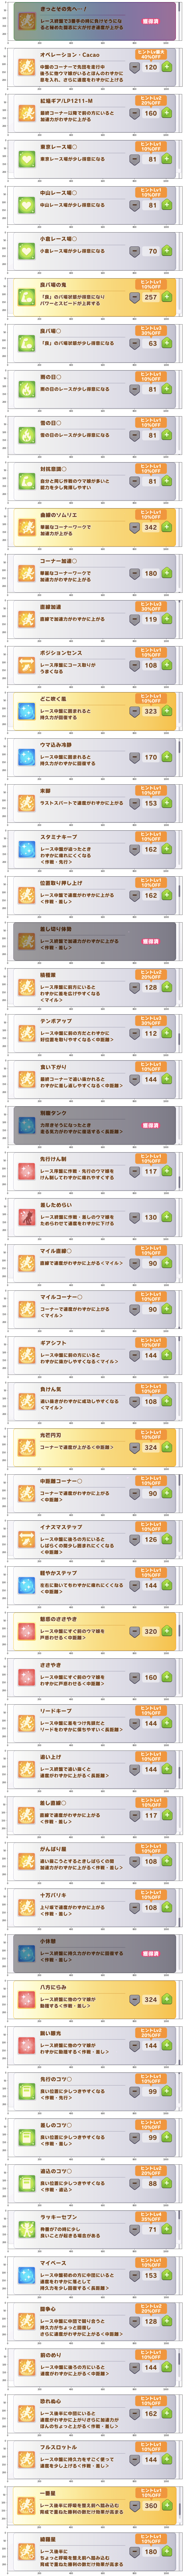

In [10]:
images = read_images(num_images, prefix, start=start, extension=extension)
skill_point, combined_img = combine_images(images)
skill_imgs = crop_delim_white(combined_img, preview=True)

### OCR images

In [11]:
def ocr_skill_images(skill_imgs, message=False):
    '''docstring
    input image of a skill, crop it, and do OCR
    '''

    print('Extracting skill hint information...')

    # for information correction
    json_open = open('json/skill_names.json')
    json_load = json.load(json_open)
    skill_names = json_load['skills']
    hint_names = json_load['hints']

    # for involved information correction
    json_open = open('json/skill_names_OCR.json')
    json_load = json.load(json_open)
    skill_names_OCR = np.array(json_load['skills'])

    skill_info = []
    for skill_img in skill_imgs:

        # thresholds for skill type determination
        thresh_gray = 180
        thresh_hue = 100

        gray_skill = cv2.cvtColor(skill_img, cv2.COLOR_BGR2GRAY)
        hsv_skill = cv2.cvtColor(skill_img, cv2.COLOR_BGR2HSV_FULL)
        if np.median(gray_skill) < thresh_gray:
            status = 0
            skill_name_txt = 'NOT READ'
            hint_level_int = 0
        else:
            if(np.median(hsv_skill[:, :, 0]) < thresh_hue):
                status = 1
            else:
                status = 2

        if status > 0:
            # crop image
            skill_height, skill_width, _ = skill_img.shape
            skill_name = skill_img[int(skill_height*0.05):int(skill_height*0.28),
                                int(skill_width*0.17):int(skill_width*0.68)]
            hint_level = skill_img[int(skill_height*0.05):int(skill_height*0.28),
                                int(skill_width*0.735):int(skill_width*0.91)]

            # thresholds for hint level OCR
            min = (0, 0, 0)
            max = (255, 255, 245)

            # digitization and OCR
            hsv = cv2.cvtColor(hint_level, cv2.COLOR_BGR2HSV_FULL)
            inrange = cv2.inRange(hsv, min, max)
            hint_level_raw = ocr_digitized_image(inrange)

            # correction by sequence match
            hint_level_txt = get_close_matches(hint_level_raw, hint_names, n=1)
            if hint_level_txt:
                hint_level_int = hint_names.index(hint_level_txt[0])
            else:
                hint_level_int = 0

            # thresholds for skill name OCR
            min = (0, 0, 145) # 140~150 may be the best
            max = (255, 255, 255)

            # digitization
            hsv = cv2.cvtColor(skill_name, cv2.COLOR_BGR2HSV_FULL)
            inrange = cv2.inRange(hsv, min, max)

            # OCR
            OCR_success = False
            langs = ['jpn+eng', 'jpn', 'eng']
            for lang in langs:
                skill_name_raw = ocr_digitized_image(inrange, lang=lang)

                # correction by sequence match
                skill_name_txt = get_close_matches(skill_name_raw, skill_names, n=1)
                skill_name_OCR_txt = get_close_matches(skill_name_raw, skill_names_OCR[:,1], n=1)

                # OCR success
                if skill_name_txt:
                    OCR_success = True
                    break
                elif skill_name_OCR_txt:
                    OCR_success = True
                    index = skill_names_OCR[:,1]==skill_name_OCR_txt
                    skill_name_txt.append(skill_names_OCR[index][0,0])
                    break
                else:
                    print('Failure in extracting skill name; lang=',lang,',',
                    skill_name_raw)

            # OCR failure
            if not OCR_success:
                imgshow(skill_img)

        # show message and save
        tmp_list = [status, skill_name_txt, hint_level_int]
        if message:
            print(tmp_list)
        skill_info.append(tmp_list)

    return skill_info

Extracting skill hint information...
Failure in extracting skill name; lang= jpn+eng , 良パ場〇
Failure in extracting skill name; lang= jpn , 良パ場〇
Failure in extracting skill name; lang= eng , BIUEBO
Failure in extracting skill name; lang= jpn+eng , AAW
Failure in extracting skill name; lang= jpn , 末朋
Failure in extracting skill name; lang= eng , AAW
Failure in extracting skill name; lang= jpn+eng , 光芝円丸
Failure in extracting skill name; lang= jpn , 光芝円丸
Failure in extracting skill name; lang= jpn+eng , マイペース
Failure in extracting skill name; lang= jpn , マイペース
Failure in extracting skill name; lang= eng , VIN--2%z
Failure in extracting skill name; lang= jpn+eng , 間争心
Failure in extracting skill name; lang= jpn , 間争心
Failure in extracting skill name; lang= eng , fedFads
Failure in extracting skill name; lang= jpn+eng , 前のめり
Failure in extracting skill name; lang= jpn , 前のめり
Failure in extracting skill name; lang= eng , HOH*)
Failure in extracting skill name; lang= jpn+eng , 2NGi
Failure in 

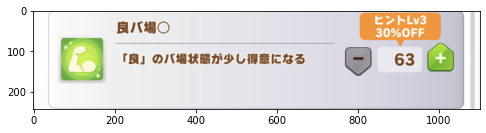

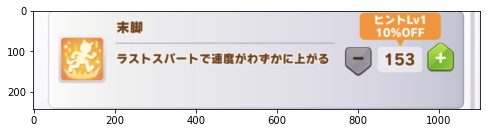

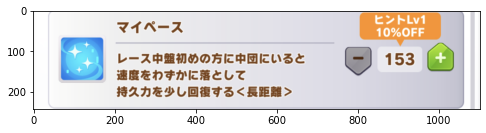

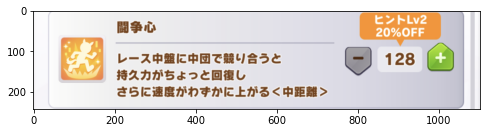

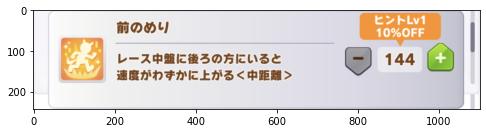

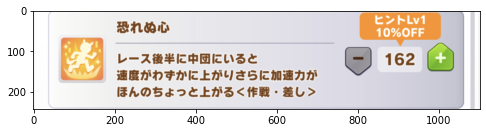

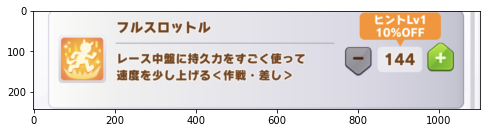

In [12]:
skill_info = ocr_skill_images(skill_imgs)

### Input and maximize

In [13]:
def maximizer(skill_info, skill_point, appropriate, timeout=30, shrewd='False', driver_path='/usr/local/bin/chromedriver'):
    '''docstring
    open gamewith maximizer and input values
    '''

    try:
        # launch Chrome
        options = Options()
        options.binary_location = "/Applications/Google Chrome Beta.app/Contents/MacOS/Google Chrome Beta"
        DRIVER_PATH = '/usr/local/bin/chromedriver-beta'
        driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)
        actions = ActionChains(driver)

        # driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

        # timeout setting
        wait = WebDriverWait(driver=driver, timeout=timeout)

        # load page
        print('Loading the GameWith maximizer...')
        load_url = 'https://gamewith.jp/uma-musume/article/show/293663'
        driver.get(load_url)

        # input skill point
        print('Inputting skill hint levels in the GameWith maximizer...')
        wait.until(EC.presence_of_element_located(
            (By.XPATH, "//input[@id='HavePoint'][@type='number']")))
        skill_point_textarea = driver.find_element(By.XPATH, "//input[@id='HavePoint'][@type='number']")
        skill_point_textarea.send_keys(str(skill_point))

        # if shrewd
        shrewd = True
        if shrewd:
            wait.until(EC.presence_of_element_located(
                (By.XPATH, "//label[@for='HasKiremono']")))
            shrewd_checkbox = driver.find_element(By.XPATH, "//label[@for='HasKiremono']")
            shrewd_checkbox.click()

        # appropriate levels
        # grass, dart, sprint, mile, middle, long, front, stalk, stay, off
        for count, app in enumerate(appropriate):
            id = "//label[@for='AppropriateSelect" + \
                str(count+1) + "_" + str(app) + "']"
            wait.until(
                EC.presence_of_element_located((By.XPATH, id)))
            appropriate_radio = driver.find_element(By.XPATH, id)
            appropriate_radio.click()

        # input hint levels
        associated_with_gold = False
        for (i, skill) in enumerate(skill_info):
            if skill[1] and skill[0] > 0:

                # search for the skill
                wait.until(EC.presence_of_element_located(
                    (By.XPATH, "//input[@id='SkillSearchText'][@type='text']")))
                hint_search_textarea = driver.find_element(By.XPATH, "//input[@id='SkillSearchText'][@type='text']")
                hint_search_textarea.clear()
                hint_search_textarea.send_keys(skill[1][0])

                # activate the skill
                if associated_with_gold:  # already activated hint
                    associated_with_gold = False
                else:
                    wait.until(EC.presence_of_element_located(
                        (By.XPATH, '//*[@id="article-body"]/div[3]/div[2]/ol[2]/li/label')))
                    skill_label = driver.find_element(By.XPATH, '//*[@id="article-body"]/div[3]/div[2]/ol[2]/li/label')
                    skill_label.click()

                # setting the hint level
                wait.until(EC.presence_of_element_located(
                    (By.XPATH, '//*[@class="_hint-button is-up"]')))
                hint_up_button = driver.find_element(By.XPATH, '//*[@class="_hint-button is-up"]')
                for i in range(skill[2]):
                    hint_up_button.click()
                    time.sleep(0.01)

                # click of a gold skill also activates the skill associated
                if skill[0] == 1:
                    associated_with_gold = True

            else:

                # normal skill associated with a gold is already acquired
                if associated_with_gold:
                    associated_with_gold = False

        # execute maximization
        # wait.until(EC.presence_of_element_located(
        #     (By.XPATH, '//*[@class="w-start-calculate js-start-calculate"]')))
        # maximizer_button = driver.find_element(By.XPATH, '//*[@class="w-start-calculate js-start-calculate"]')
        # driver.execute_script('arguments[0].click();', maximizer_button)
        # print('Maximization completed!')

        # show maximization area
        # wait.until(EC.presence_of_element_located((By.XPATH, '//*[@class="w-share-wrap"]')))
        # maximizer_area = driver.find_element(By.XPATH, '//*[@class="w-share-wrap"]')
        # actions.move_to_element(maximizer_area).perform()

        # Wait for keyboard input before closing
        input('Press Enter to quit.')

    finally:
        driver.quit()
        print('Process quitted.')

In [14]:
appropriate = [1, 4, 3, 2, 1, 1, 1, 2, 3, 4]  # 1 [SA] 2 [BC] 3 [DEF] 4[G]
maximizer(skill_info, skill_point, appropriate, timeout=60)

<ipython-input-13-c81e9aa09806>:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)


Loading the GameWith maximizer...
Inputting skill hint levels in the GameWith maximizer...
Process quitted.
